<a href="https://colab.research.google.com/github/SsyMa/OceanGate/blob/main/notebooks/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading model ###

In [ ]:
import sys
sys.path.append('..')

from keras.models import load_model
from src.metrics import iou_metric, f2_metric

model = load_model("../model.keras")

### Tensorboard ###

In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
%tensorboard --logdir ../logs

Reusing TensorBoard on port 6006 (pid 16389), started 0:06:41 ago. (Use '!kill 16389' to kill it.)

### Evaluate ###

In [6]:
from src.data_loader import ShipDatasetLoader
from config import (TRAIN_IMAGES_DIR, TRAIN_METADATA_CSV, IMG_SIZE, VALIDATION_SPLIT, BATCH_SIZE)

In [7]:
loader = ShipDatasetLoader(
    train_image_dir=TRAIN_IMAGES_DIR,
    masks_csv_path=TRAIN_METADATA_CSV,
    img_size=IMG_SIZE
)

train_ds, val_ds = loader.train_val_split(
    val_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE
)

Dataset statistics:
  Total unique images: 192556
  Images with ships: 42556
  Images without ships: 150000
Train/Validation Split:
  Train set: 154044 images
  Validation set: 38512 images
TRAIN_LOADER LEN: 154044
VAL_LOADER LEN: 38512
Balanced dataset: 68090 images (50% with ships, 50% without)


### Note ###
*Since the competition doesn't provide labels for the test dataset, and right now we didn't saved the exact validation set used on the training of this model, we will evaluate the performance on the training dataset for now.*

In [ ]:
eval_results = model.evaluate(
    val_ds,
    steps = 1200
    )

### Results ###

In [9]:
print(f"Binarry crossentropy loss: {eval_results[0]}")
print(f"Intersection over Union: {eval_results[1]} / 1.0")
print(f"f2 metric: {eval_results[2]} / 1.0")

Binarry crossentropy loss: 0.0010770915541797876
Intersection over Union: 0.6649565696716309 / 1.0
f2 metric: 0.7606819868087769 / 1.0


### Visualization ###

In [10]:
import numpy as np
import tensorflow as tf
# Helper function for visualization
def make_overlay(image, mask, alpha=0.5, color=[1.0, 0.0, 0.0]):
    img = tf.keras.backend.get_value(image) if tf.is_tensor(image) else np.array(image)
    msk = tf.keras.backend.get_value(mask)  if tf.is_tensor(mask)  else np.array(mask)

    overlay = img.copy()
    ship = np.where(msk.squeeze() > 0)
    for c in range(3):
        chan = overlay[..., c]
        chan[ship] = (1 - alpha) * chan[ship] + alpha * color[c]
        overlay[..., c] = chan
    return overlay

Image shape: (256, 256, 3)
mask shape: (256, 256, 1)


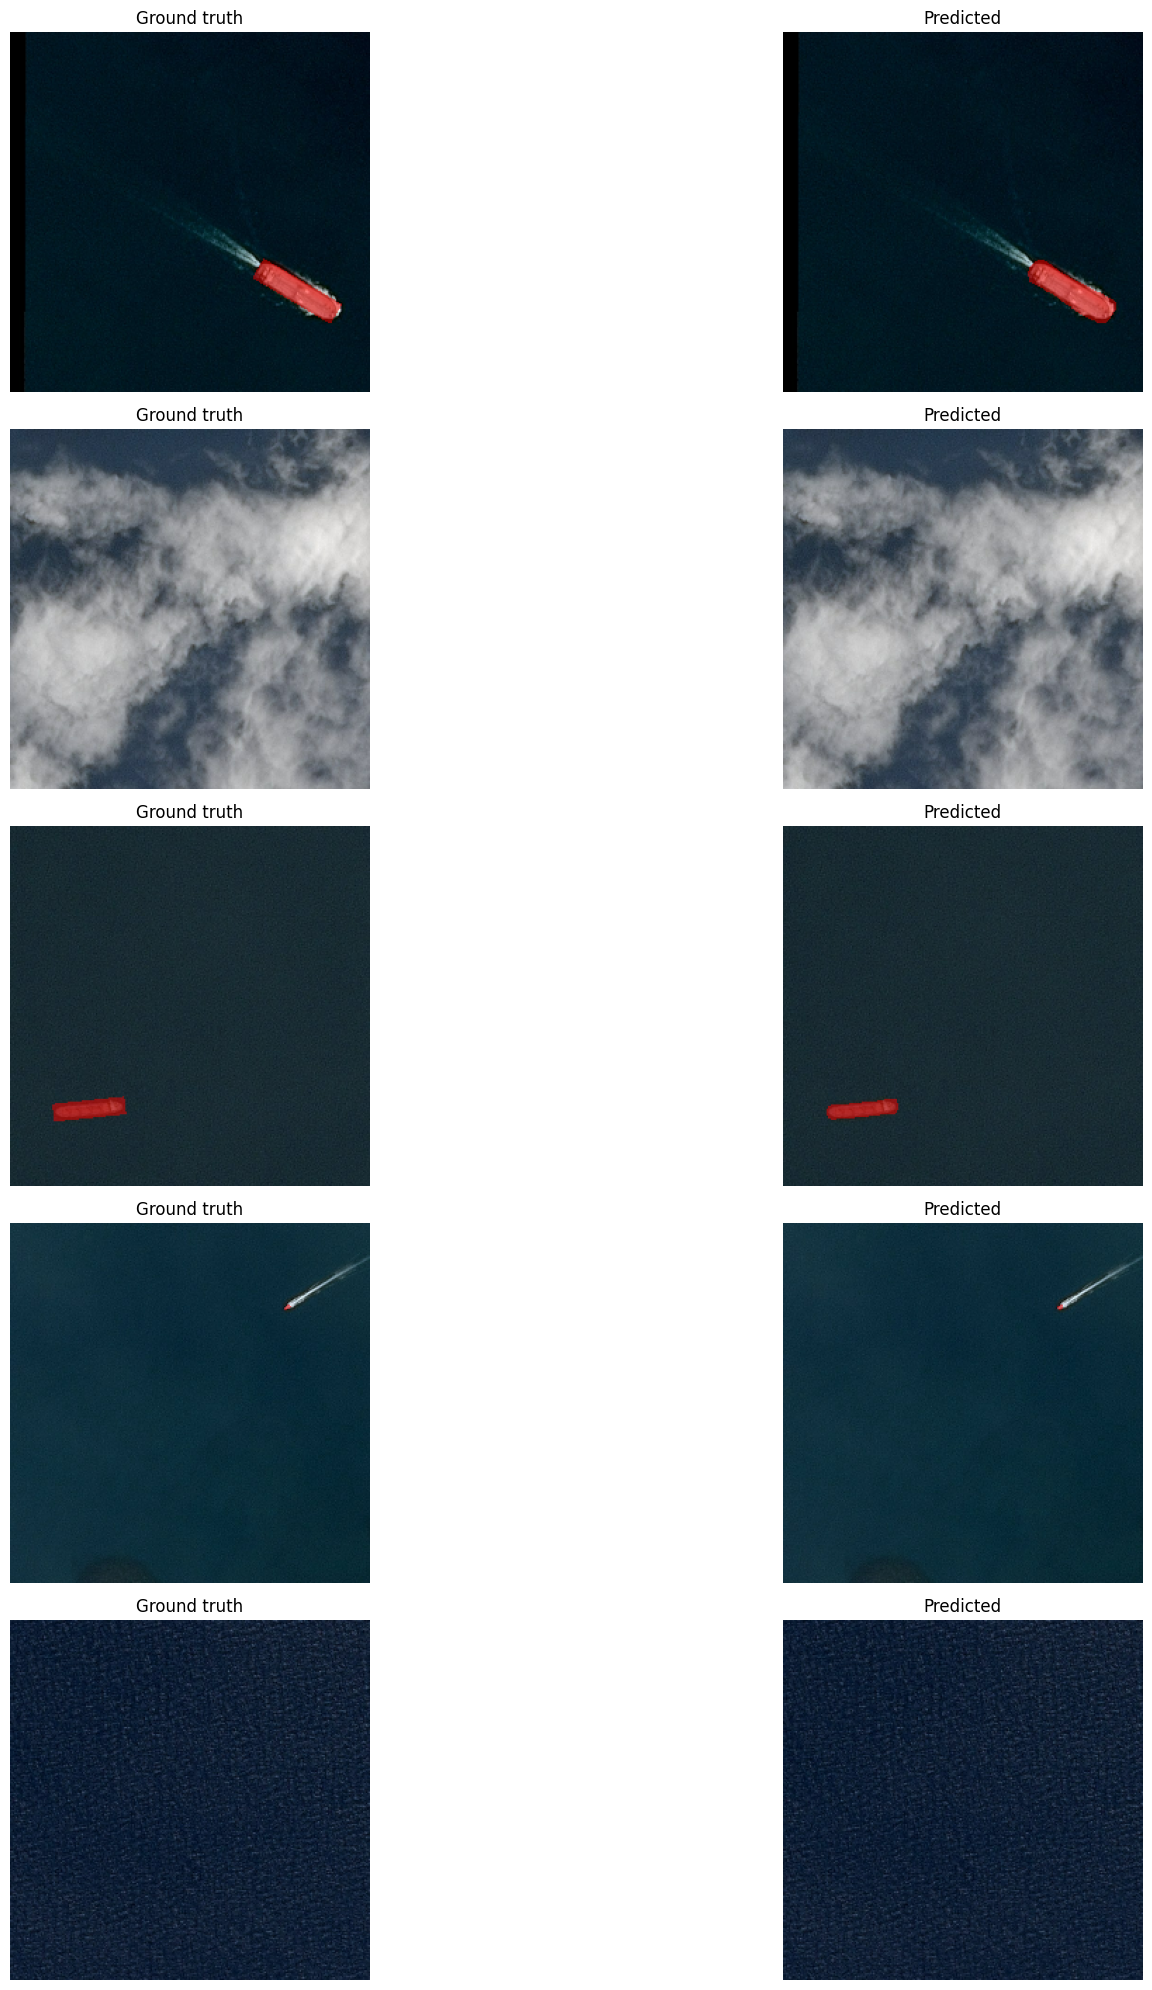

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(20, 20))

batchOfInputs = train_ds.take(1)
for images, masks in batchOfInputs:
    print(f"Image shape: {images.shape[1:]}")
    print(f"mask shape: {masks.shape[1:]}")
    imagesToShow = images[:5]
    masksToShow = masks[:5]
    for y in range(5):
        for x in range(2):
            if x == 1:
                pred_logits = model.predict(tf.expand_dims(images[y], axis=0), verbose=0)
                pred_mask = (pred_logits[0] > 0.0).astype(np.float32)
                axes[y, x].imshow(make_overlay(images[y], pred_mask))
            else:
                axes[y, x].imshow(make_overlay(images[y], masks[y]))
            axes[y, x].set_title("Ground truth" if x==0 else "Predicted")
            axes[y, x].axis("off")
    break

plt.tight_layout()
plt.show()
